## Read in an SP mode run and calculate target LAI for each PFT

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import rioxarray as rx
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

#import functions_py.fates_xarray_functions as fa

from cartopy.io.shapereader import Reader
import shapefile
from shapely.geometry import shape, Point, LinearRing

import regionmask

from shapely.geometry import MultiPolygon, Polygon

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load FATES

In [2]:
fates = '/pscratch/sd/j/jneedham/elm_runs/sp_cal/sp_f09_g16_full.E64046ec755-Ffe782ba4.2025-05-19/run/sp_f09_g16_full.E64046ec755-Ffe782ba4.2025-05-19.elm.h0.1900-01.nc'
fates = xr.open_dataset(fates, decode_times=False)

In [3]:
# extract lat and lon coords
fates_lon = fates.coords['lon']
fates_lat = fates.coords['lat']

### Load the domain  file   and get the area of active  FATES and the  area of grid  cells

In [4]:
domain = '/global/cfs/cdirs/e3sm/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v6.090309.nc'
domain = xr.open_dataset(domain, decode_times=False)

In [5]:
domain = domain.rename({'nj': 'lat', 'ni':'lon'})

# Make sure they have identical dimensions and coordinates as FATES in terms of lat and lon
frac = domain.frac
frac = frac.assign_coords({'lon':fates_lon})
frac = frac.assign_coords({'lat':fates_lat})
area = domain.area
area = area.assign_coords({'lon':fates_lon})
area = area.assign_coords({'lat':fates_lat})

In [6]:
fates_frac = fates.FATES_FRACTION.mean(dim='time')
fates_active = fates_frac * frac

### Open the surface data file so we can get proportion of PFT on each grid cell

In [7]:
surfdata = '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/surfdata_map/surfdata_0.9x1.25_simyr2000_c180404.nc'
surfdata = xr.open_dataset(surfdata, decode_times=False)


In [8]:
surfdata = surfdata.rename({'lsmlat': 'lat', 'lsmlon':'lon'})

In [9]:
pfts = surfdata.PCT_NAT_PFT
pfts = pfts.assign_coords({'lon':fates_lon})
pfts = pfts.assign_coords({'lat':fates_lat})

### Find grid cells dominated by tropical PFTs 

In [10]:
print(pfts.coords)

Coordinates:
  * natpft   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


In [11]:
pfts_t = pfts.sel(lat=slice(-30,30))

In [12]:
print(pfts_t.shape)

(17, 64, 288)


In [13]:
def convert_longitude(lon):
    return lon % 360

In [14]:
convert_longitude(55)

55

In [15]:
pfts_am = pfts_t.sel(lon=slice(180,340))
pfts_af = pfts_t.sel(lon=slice(340,55))
pfts_as = pfts_t.sel(lon=slice(55,180))

In [16]:
print(pfts_am.shape)

(17, 64, 129)


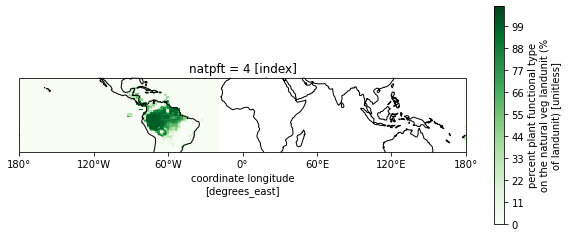

In [87]:
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,4))

clevs=np.arange(0,110,1)
cs = pfts_am.isel(natpft=4).plot(levels=clevs,cmap='Greens', ax=axs, label='Area')
axs.coastlines()

# Define the xticks for longitude
axs.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

### Make a mask of where nat pfts 4 and 6 fill more than 70% of the grid cell

In [88]:
pfts_am_rf = pfts_am.isel(natpft=4)
mask_am_rf = pfts_am_rf.where(pfts_am_rf.natpft > 70)
print(mask_am_rf.shape)

pfts_am_df = pfts_am.isel(natpft=6)
mask_am_df = pfts_am_df.where(pfts_am_df.natpft > 70)
print(mask_am_df.shape)

(64, 129)
(64, 129)


### Extract total LAI

In [89]:
lai = fates.FATES_LAI.mean(dim='time') * fates_active
lai_t = lai.sel(lat=slice(-30,30))

In [90]:
lai_am = lai_t.sel(lon=slice(180,340))
lai_af = lai_t.sel(lon=slice(340,55))
lai_as = lai_t.sel(lon=slice(55,180))

In [91]:
lai_am_rf = lai_am.where(mask_am_rf, drop=True)
print(lai_am_rf.shape)

(64, 129)


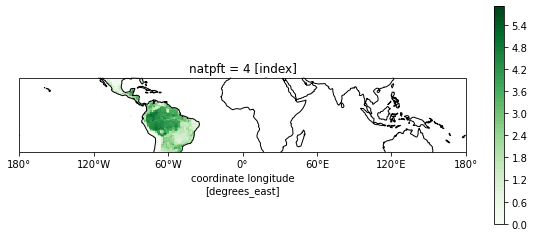

In [92]:
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,4))

clevs=np.arange(0,6,0.1)
cs = lai_am_rf.plot(levels=clevs,cmap='Greens', ax=axs, label='Area')
axs.coastlines()

# Define the xticks for longitude
axs.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

In [93]:
lai_am_df = lai_am.where(mask_am_df, drop=True)
#lai_am_df_weighted = lai_am_df.weighted(area)
lai_weighted_mean = lai_am_df.mean(dim=('lat','lon'))

In [94]:
print(lai_weighted_mean)

<xarray.DataArray ()>
array(2.15393627)
Coordinates:
    natpft   int32 6


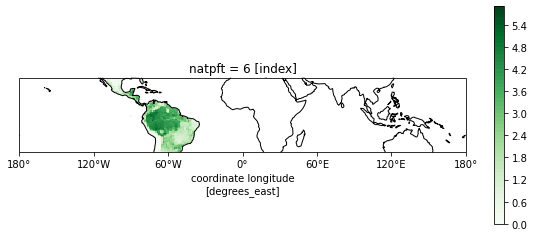

In [95]:
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,4))

clevs=np.arange(0,6,0.1)
cs = lai_am_df.plot(levels=clevs,cmap='Greens', ax=axs, label='Area')
axs.coastlines()

# Define the xticks for longitude
axs.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

## IGNORE cells below - no good way to divide up by region 

### Read in MODIS LAI

In [13]:
modis_lai_ds =  '/pscratch/sd/j/jneedham/ILAMB/DATA/lai/MODIS/lai_0.5x0.5.nc'
modis_lai_ds = xr.open_dataset(modis_lai_ds, decode_times=False)

modis_lai = modis_lai_ds.lai
modis_lai = modis_lai.mean(dim='time') 

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'lai' has multiple fill values {1e+36, -999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [14]:
lon=modis_lai.lon
lat=modis_lai.lat
lon_grid, lat_grid = np.meshgrid(lon,lat)

### Read in AVHRR LAI

In [15]:
avhrr_lai_ds = '/pscratch/sd/j/jneedham/ILAMB/DATA/lai/AVHRR/lai_0.5x0.5.nc'
avhrr_lai_ds = xr.open_dataset(avhrr_lai_ds, decode_times=False)

avhrr_lai = avhrr_lai_ds.lai
avhrr_lai = avhrr_lai.mean(dim='time') 

In [16]:
lon=avhrr_lai.lon
lat=avhrr_lai.lat
lon_grid, lat_grid = np.meshgrid(lon,lat)

In [17]:
print(lon.coords)
print(lat.coords)

Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75


### Amazon

In [18]:
Amazon_shapefile='/global/homes/j/jneedham/Rdark_scripts/amazon_ecolola.shp'
r = shapefile.Reader(Amazon_shapefile)
shapes = r.shapes()
polygon = shape(shapes[0])

In [19]:
# shapefile must contain center point of grid cell
AmzMask = [[1 if polygon.contains(Point(lon_grid[j,i],lat_grid[j,i]))==True else 0 for i in range(720)] for j in range(360)]
AmzMask = np.array(AmzMask, dtype='int16')

In [20]:
amazon_modis_lai = modis_lai.where(AmzMask==1)
amazon_modis_lai_mean = amazon_modis_lai.mean(dim=('lat','lon'),skipna=True)

print(amazon_modis_lai_mean)

<xarray.DataArray 'lai' ()>
array(4.061153, dtype=float32)


In [21]:
amazon_avhrr_lai = avhrr_lai.where(AmzMask==1)
amazon_avhrr_lai_mean = amazon_avhrr_lai.mean(dim=('lat','lon'),skipna=True)

print(amazon_avhrr_lai_mean)

<xarray.DataArray 'lai' ()>
array(4.209164, dtype=float32)


In [23]:
amazon_lai_mean = np.mean([amazon_modis_lai_mean.values, amazon_avhrr_lai_mean.values])

print(amazon_lai_mean)

4.1351585


###  S.America dry forest

In [45]:
mask_modis = regionmask.defined_regions.srex.mask(modis_lai)
mask_avhrr = regionmask.defined_regions.srex.mask(avhrr_lai)
sam_dry_index = 8
mask_sam_dry_modis = mask_modis == sam_dry_index
mask_sam_dry_avhrr = mask_avhrr == sam_dry_index

In [46]:
modis_lai_sam_dry = modis_lai.where(mask_sam_dry_modis)
avhrr_lai_sam_dry = avhrr_lai.where(mask_sam_dry_avhrr)

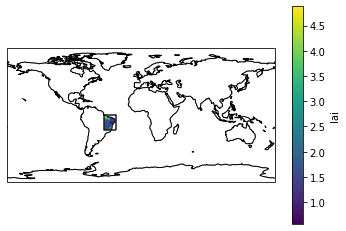

In [47]:
# choose a good projection for regional maps
proj = ccrs.PlateCarree()

ax = plt.subplot(projection=proj)

regionmask.defined_regions.srex[[8]].plot(ax=ax, add_label=False)

modis_lai_sam_dry.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

In [50]:
weights = np.cos(np.deg2rad(modis_lai.lat))
weighted_modis_lai_sam_dry = modis_lai_sam_dry.weighted(weights).mean(dim=('lat','lon'))
weighted_avhrr_lai_sam_dry = avhrr_lai_sam_dry.weighted(weights).mean(dim=('lat','lon'))
print(weighted_modis_lai_sam_dry.values)
print(weighted_avhrr_lai_sam_dry.values)


1.9934818307013096
2.0670843180288947


In [51]:
sam_dry_lai_mean = np.mean([weighted_modis_lai_sam_dry.values, weighted_avhrr_lai_sam_dry.values])

print(sam_dry_lai_mean)

2.0302830743651024


### South East Asia

In [55]:
sea_index = 24
mask_sea_modis = mask_modis == sea_index
mask_sea_avhrr = mask_avhrr == sea_index

In [56]:
modis_lai_sea = modis_lai.where(mask_sea_modis)
avhrr_lai_sea = avhrr_lai.where(mask_sea_avhrr)

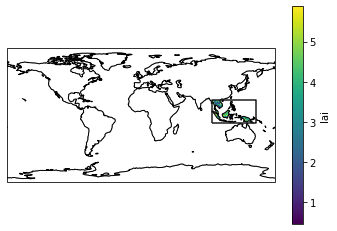

In [57]:
# choose a good projection for regional maps
proj = ccrs.PlateCarree()

ax = plt.subplot(projection=proj)

regionmask.defined_regions.srex[[24]].plot(ax=ax, add_label=False)

modis_lai_sea.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

In [58]:
weighted_modis_lai_sea = modis_lai_sea.weighted(weights).mean(dim=('lat','lon'))
weighted_avhrr_lai_sea = avhrr_lai_sea.weighted(weights).mean(dim=('lat','lon'))
print(weighted_modis_lai_sea.values)
print(weighted_avhrr_lai_sea.values)


3.6821172383850094
3.4116002839658406


In [59]:
sea_lai_mean = np.mean([weighted_modis_lai_sea.values, weighted_avhrr_lai_sea.values])

print(sea_lai_mean)

3.546858761175425


### Africa rainforest

In [60]:
afr_rf_index = 15
mask_afr_rf_modis = mask_modis == afr_rf_index
mask_afr_rf_avhrr = mask_avhrr == afr_rf_index

In [61]:
modis_lai_afr_rf = modis_lai.where(mask_afr_rf_modis)
avhrr_lai_afr_rf = avhrr_lai.where(mask_afr_rf_avhrr)

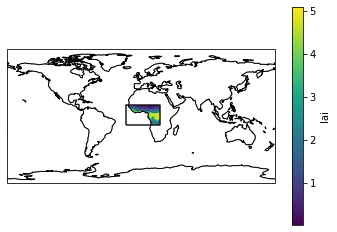

In [62]:
# choose a good projection for regional maps
proj = ccrs.PlateCarree()

ax = plt.subplot(projection=proj)

regionmask.defined_regions.srex[[15]].plot(ax=ax, add_label=False)

modis_lai_afr_rf.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

In [63]:
weighted_modis_lai_afr_rf = modis_lai_afr_rf.weighted(weights).mean(dim=('lat','lon'))
weighted_avhrr_lai_afr_rf = avhrr_lai_afr_rf.weighted(weights).mean(dim=('lat','lon'))
print(weighted_modis_lai_afr_rf.values)
print(weighted_avhrr_lai_afr_rf.values)


2.153968584663223
2.085382928941211


In [64]:
afr_rf_lai_mean = np.mean([weighted_modis_lai_afr_rf.values, weighted_avhrr_lai_afr_rf.values])

print(afr_rf_lai_mean)

2.1196757568022173


### Africa Savanna

In [65]:
afr_df_index = 16
mask_afr_df_modis = mask_modis == afr_df_index
mask_afr_df_avhrr = mask_avhrr == afr_df_index

In [66]:
modis_lai_afr_df = modis_lai.where(mask_afr_df_modis)
avhrr_lai_afr_df = avhrr_lai.where(mask_afr_df_avhrr)

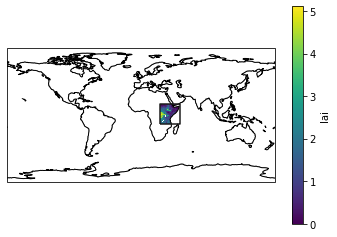

In [67]:
# choose a good projection for regional maps
proj = ccrs.PlateCarree()

ax = plt.subplot(projection=proj)

regionmask.defined_regions.srex[[16]].plot(ax=ax, add_label=False)

modis_lai_afr_df.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

In [69]:
weighted_modis_lai_afr_df = modis_lai_afr_df.weighted(weights).mean(dim=('lat','lon'))
weighted_avhrr_lai_afr_df = avhrr_lai_afr_df.weighted(weights).mean(dim=('lat','lon'))
print(weighted_modis_lai_afr_df.values)
print(weighted_avhrr_lai_afr_df.values)


1.4277029856456829
1.5747932669556945


In [70]:
afr_df_lai_mean = np.mean([weighted_modis_lai_afr_df.values, weighted_avhrr_lai_afr_df.values])

print(afr_df_lai_mean)

1.5012481263006887
